# Linear Regression and Web Scraping Project

In this project we are going to web scraping information about stock prices and financial statistic numbers of about 1000 public companies. We will run linear regression models on stock price.

In [5]:
import time, os
import requests 
from bs4 import BeautifulSoup as bs
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import Select

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import time, os

In [7]:
import pickle

## 1. Web Scraping

###  Collect ticker list info from website  ```https://stockanalysis.com/stocks/```

In [8]:
# Webdriver set up
options = webdriver.ChromeOptions()
chrome_driver_binary = "/Applications/chromedriver" # path to the chromedriver executable
os.environ["webdriver.chrome.driver"] = chrome_driver_binary
options.binary_location = "/Applications/Google Chrome .app/Contents/MacOS/Google Chrome"

In [ ]:
driver = webdriver.Chrome(chrome_driver_binary, chrome_options=options)

The following code is the process of scraping company tickers info from websti ``` https://stockanalysis.com/stocks/``` and save the first 5000 tickers in a dataframe ```df_ticker```.

In [9]:
from os import path

In [10]:
if path.exists('ticker_5000.pickle') == False: 
    url_query = 'https://stockanalysis.com/stocks/'
    driver.get(url_query)

    select_number  = driver.find_element_by_xpath('//*[@id="main"]/div/div/nav/div/select')
    select_number.send_keys('10000')
    soup = bs(driver.page_source, 'html.parser')
    driver.quit()
    table = []
    extract_table = soup.find('tbody').find_all('tr')
    for tr in extract_table:
        t_row = [td.text.replace('\n','').strip() for td in tr.find_all('td')]

        table.append(t_row)
    df_ticker =pd.DataFrame(table)
    df_ticker.columns= ['Ticker','Company','Industry','Market_Cap']
    df_ticker['Market_Cap_num'] = df_ticker.Market_Cap.map(lambda x : str(x)[0:-1])
    df_ticker['Market_metric']  = df_ticker.Market_Cap.map(lambda x : str(x)[-1])
    df_ticker.Market_Cap_num= pd.to_numeric(df_ticker.Market_Cap_num, errors='coerce')
    df_ticker['MARKET_CAP'] = (
        np.where(df_ticker['Market_metric'] =='B',
        df_ticker['Market_Cap_num']*10**9,df_ticker['Market_Cap_num']*10**6))
    df_ticker.drop(columns = ['Market_metric','Market_Cap_num'],inplace = True)

    with open('ticker_5000.pickle', 'wb') as handle:
        pickle.dump(df_ticker, handle)
else:
    with open('ticker_5000.pickle', 'rb') as handle:
        df_ticker = pickle.load(handle)

In [11]:
df_ticker= df_ticker[:5000]
ticker_list = df_ticker['Ticker']
ticker_list.size

5000

###  Go to yahoo website and web scrape financial numbers/info for one company.

In [12]:
def collect_company_info(company_ticker):
    df = None
    #driver =webdriver.Chrome(chrome_driver_binary, chrome_options=options)
    url_query = 'https://finance.yahoo.com/'
    driver.get(url_query)
    try:
        cor_input = (WebDriverWait(driver, 20).until(
            EC.presence_of_element_located((By.ID, "yfin-usr-qry")))
                    )
    except:
        print('111111')
        return df

    cor_input.send_keys(company_ticker)
    cor_input.send_keys(Keys.RETURN)
    ##############################
    # parse summary page
    #soup = bs(driver.page_source,"html.parser")
    ##############################
  
    
    fin_summary =[]
    try:
        summary = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.ID, "quote-summary"))
        )
        trs = summary.find_elements_by_tag_name('tr')
        for tr in trs:
            t_rows = [td.text.replace('\n','').strip() for td in tr.find_elements_by_tag_name('td')]
            fin_summary.append(t_rows)

    except:
        print('222222')
        
    if len(fin_summary) !=16:
        print('333333')
        return df

    fin_summary = pd.DataFrame(fin_summary).iloc[[0,7,9,10,11,15],:]
    fin_summary.reset_index(inplace = True,drop = True)
    
    
    ##############################
    # parse statistic page
    ##############################
    try:
        statistics = driver.find_element_by_link_text('Statistics')
        statistics.click()
        WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.ID, "Col1-0-KeyStatistics-Proxy")))
    except:
        print('444444')
        return df
    
    
    soup = bs(driver.page_source,'html.parser')
    
    ##############################
    fin_statistic =[]

    
    try:
        s1 = soup.find('div', class_="Pstart(20px) smartphone_Pstart(0px)")
        trs= s1.find_all('tr')
        for tr in trs:
            t_rows = [td.text.replace('\n','').strip() for td in tr.find_all('td')]
            fin_statistic.append(t_rows)
    except:
        print('666666')
        return df
    
    try:
        s2 = soup.find('div', class_="Mb(10px) Pend(20px) smartphone_Pend(0px)")
        trs= s2.find_all('tr')
        for tr in trs:
            t_rows = [td.text.replace('\n','').strip() for td in tr.find_all('td')]
            fin_statistic.append(t_rows)
    except:
        print('777777')
        return df

    ##########################        
    fin_statistic =pd.DataFrame(fin_statistic)
    df =pd.concat([fin_summary,fin_statistic]).reset_index(drop=True)
    df.loc[-1]= ['Company',company_ticker]  # add company name and ticker as a column
    df.index = df.index + 1  # shifting index
    df.sort_index(inplace=True)
    df = df.T
    df.columns = df.loc[0,:]
    df.drop(labels =0,axis = 0,inplace = True)
    return df


data collect example

In [14]:
driver= webdriver.Chrome(chrome_driver_binary, chrome_options=options)
df = collect_company_info('T')
driver.quit()

/var/folders/py/tfswslv1637f5tfr0ngkmsgr0000gn/T/ipykernel_94838/748361899.py:1: DeprecationWarning: use options instead of chrome_options
  driver= webdriver.Chrome(chrome_driver_binary, chrome_options=options)


###  Create a pipleline for all company in the ticker_list

In [15]:
###### Due to long peiod of running this cell to scrap data, once data collected successfully, make it markedown
######  Data was save as all_company5000_final.pickle, download pickle data if needed
if path.exists('all_company5000_final.pickle') == False: 
    all_com = list()
    start_time = time.time()
    for y in range(50):
        session_time = time.time()
        driver= webdriver.Chrome(chrome_driver_binary, chrome_options=options)
        start = 0+ 100*y
        end  = 100 + 100* y
        for i,com in enumerate(ticker_list[start:end]):
            print("session: {}".format(y),i+100*y,com)
            try:
                df = collect_company_info(com)
                time.sleep(1)
            except MaxRetryError:
                print("MaxRetryError")        
            if df is not None:
                df_dict = df.to_dict('records')
                all_com.append(df_dict[0])
        driver.quit()
        with open('all_company{}.pickle'.format(y), 'wb') as handle:
            pickle.dump(all_com, handle)
        print("session:{}".format(y),"used --- %s seconds ---" % (time.time() -  session_time))
    collect_time = time.time() -  start_time
    print("total used --- %s seconds ---" % (collect_time ))
else:
    with open('all_company5000_final.pickle', 'rb') as handle:
        all_com = pickle.load(handle)


    

In [16]:
df_all_com = pd.DataFrame(all_com)


In [516]:
df_all_com

,Company,Previous Close,Avg. Volume,Beta (5Y Monthly),PE Ratio (TTM),EPS (TTM),1y Target Est,52-Week Change 3,S&P500 52-Week Change 3,52 Week High 3,...,Short % of Float 4,Short % of Shares Outstanding 4,Shares Short (prior month ) 4,"Shares Short (Jun 30, 2021) 4","Short Ratio (Jun 30, 2021) 4","Short % of Float (Jun 30, 2021) 4","Short % of Shares Outstanding (Jun 30, 2021) 4","Shares Short (prior month May 28, 2021) 4","Shares Short (prior month Jul 30, 2021) 4","Shares Short (prior month Nov 13, 2020) 4"
0,AA,49.77,"7,737,382",2.58,21.35,2.30,55.03,326.48%,29.64%,52.45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AACG,2.4000,"903,300",1.19,N/A,-0.2840,26.00,116.22%,29.64%,19.7500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAIC,3.7100,"183,431",1.80,740.00,0.0050,4.50,32.03%,29.64%,4.4200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAL,21.65,"31,919,941",1.71,N/A,-9.85,19.55,72.79%,29.64%,26.09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAMC,24.11,"61,007",0.80,0.33,69.55,N/A,17.61%,29.64%,31.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3052,SSYS,21.71,"875,515",1.16,N/A,-7.41,25.00,62.26%,27.95%,56.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3053,ST,55.57,"757,010",1.41,24.44,2.30,65.83,22.16%,27.95%,64.80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3054,STAB,2.3200,"275,501",N/A,N/A,-0.9230,N/A,12.62%,27.95%,10.9700,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.41k,NaN
3055,STAF,1.9200,"1,869,470",1.64,N/A,-2.0930,5.50,-47.54%,27.95%,20.0400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Data cleaning and EDA

In [17]:
df_all_com.columns

Index(['Company', 'Previous Close', 'Avg. Volume', 'Beta (5Y Monthly)',
       'PE Ratio (TTM)', 'EPS (TTM)', '1y Target Est', '52-Week Change 3',
       'S&P500 52-Week Change 3', '52 Week High 3', '52 Week Low 3',
       '50-Day Moving Average 3', '200-Day Moving Average 3',
       'Avg Vol (3 month) 3', 'Avg Vol (10 day) 3', 'Shares Outstanding 5',
       'Implied Shares Outstanding 6', 'Float 8', '% Held by Insiders 1',
       '% Held by Institutions 1', 'Shares Short (Sep 15, 2021) 4',
       'Short Ratio (Sep 15, 2021) 4', 'Short % of Float (Sep 15, 2021) 4',
       'Short % of Shares Outstanding (Sep 15, 2021) 4',
       'Shares Short (prior month Aug 13, 2021) 4',
       'Forward Annual Dividend Rate 4', 'Forward Annual Dividend Yield 4',
       'Trailing Annual Dividend Rate 3', 'Trailing Annual Dividend Yield 3',
       '5 Year Average Dividend Yield 4', 'Payout Ratio 4', 'Dividend Date 3',
       'Ex-Dividend Date 4', 'Last Split Factor 2', 'Last Split Date 3',
       'Fisca

In [18]:
df_all_com.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3057 entries, 0 to 3056
Data columns (total 69 columns):
 #   Column                                          Non-Null Count  Dtype 
---  ------                                          --------------  ----- 
 0   Company                                         3057 non-null   object
 1   Previous Close                                  3057 non-null   object
 2   Avg. Volume                                     3057 non-null   object
 3   Beta (5Y Monthly)                               3057 non-null   object
 4   PE Ratio (TTM)                                  3057 non-null   object
 5   EPS (TTM)                                       3057 non-null   object
 6   1y Target Est                                   3057 non-null   object
 7   52-Week Change 3                                3057 non-null   object
 8   S&P500 52-Week Change 3                         3057 non-null   object
 9   52 Week High 3                                  3057

We will drop columns with large number of Null value and combine with ```MARKET_CAP``` from df_ticker

In [20]:
#df_cl_select = df_all_com[select_col]
df_cl_select = df_all_com.iloc[:,0:57]
df_cl_select = pd.concat([df_cl_select,df_ticker[['Ticker','MARKET_CAP']]], axis=1, join="inner")
df_cl_select.set_index('Company',inplace = True)
df_cl_select.drop(columns='Ticker',inplace = True)

transform object strucure into float data type.

In [21]:
str_to_numeric_list = (['Previous Close','Avg. Volume','Beta (5Y Monthly)',
               'PE Ratio (TTM)','EPS (TTM)','1y Target Est','52 Week High 3','52 Week Low 3',
               '50-Day Moving Average 3','200-Day Moving Average 3','Short Ratio (Sep 15, 2021) 4',
                'Forward Annual Dividend Rate 4', 'Trailing Annual Dividend Rate 3',                      
              '5 Year Average Dividend Yield 4','Revenue Per Share (ttm)',
              'Diluted EPS (ttm)','Total Cash Per Share (mrq)','Total Debt/Equity (mrq)',
            'Current Ratio (mrq)','Book Value Per Share (mrq)','MARKET_CAP']
             )
print(len(str_to_numeric_list))


Perc_to_numeric_list = (['52-Week Change 3','% Held by Insiders 1','% Held by Institutions 1',
                         'Profit Margin','Operating Margin (ttm)','Short % of Shares Outstanding (Sep 15, 2021) 4',
                         'Short % of Float (Sep 15, 2021) 4','Forward Annual Dividend Yield 4',
                         'Trailing Annual Dividend Yield 3','Payout Ratio 4','Return on Assets (ttm)',
                         'Return on Equity (ttm)','Quarterly Revenue Growth (yoy)','Quarterly Earnings Growth (yoy)'])
print(len(Perc_to_numeric_list))



TBMK_to_numeric_list =(['Avg Vol (3 month) 3','Avg Vol (10 day) 3',
                        'Shares Outstanding 5','Implied Shares Outstanding 6','Shares Short (Sep 15, 2021) 4',
                        'Shares Short (prior month Aug 13, 2021) 4',
                      'Revenue (ttm)',
                      'Gross Profit (ttm)','EBITDA','Net Income Avi to Common (ttm)','Total Cash (mrq)','Total Debt (mrq)',
                        'Operating Cash Flow (ttm)','Levered Free Cash Flow (ttm)'])
print(len(TBMK_to_numeric_list))

21
14
14


In [22]:
for feature in str_to_numeric_list:
    df_cl_select[feature]= pd.to_numeric(df_cl_select[feature].replace(',',''),errors= 'coerce')
for feature in Perc_to_numeric_list:
    df_cl_select[feature]= (pd.to_numeric(
        df_cl_select[feature].str.replace('%',''),errors= 'coerce'))    

In [23]:
def per_to_num(column):
    ls = []
    for value in df_cl_select[column]:
        n_value = str(value)
        s = str(value)[-1]
        if s == 'k':
            n_value = float(str(value)[0:-1])*10**3
        if s == 'M':
            n_value = float(str(value)[0:-1])*10**6
        elif s == 'B':
            n_value = float(str(value)[0:-1])*10**9
        elif s == 'T':
            n_value = float(str(value)[0:-1])*10**12
        elif s == 'A':
            n_value = 'N/A'
        ls.append(n_value)
    return ls
    
for col in TBMK_to_numeric_list:
    df_cl_select[col] = per_to_num(col)

for col in TBMK_to_numeric_list:
    df_cl_select[col] = pd.to_numeric(df_cl_select[col],errors= 'coerce')

In [24]:
df_cl_select = df_cl_select[str_to_numeric_list + Perc_to_numeric_list +TBMK_to_numeric_list]
df_cl_select.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3057 entries, AA to STAG
Data columns (total 49 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Previous Close                                  3048 non-null   float64
 1   Avg. Volume                                     12 non-null     float64
 2   Beta (5Y Monthly)                               2291 non-null   float64
 3   PE Ratio (TTM)                                  1490 non-null   float64
 4   EPS (TTM)                                       2780 non-null   float64
 5   1y Target Est                                   2210 non-null   float64
 6   52 Week High 3                                  3047 non-null   float64
 7   52 Week Low 3                                   3050 non-null   float64
 8   50-Day Moving Average 3                         3047 non-null   float64
 9   200-Day Moving Average 3                     

For the purpose of accuarcy of regression model, we will drop the columns with too many 'nan' values and drop rows with zero values.

In [25]:
final_col = (['Previous Close','MARKET_CAP','Beta (5Y Monthly)', 'PE Ratio (TTM)',
       'EPS (TTM)', '1y Target Est', '52 Week High 3', '52 Week Low 3',
       '50-Day Moving Average 3', '200-Day Moving Average 3',
       'Short Ratio (Sep 15, 2021) 4', 'Forward Annual Dividend Rate 4',
       'Trailing Annual Dividend Rate 3', '5 Year Average Dividend Yield 4',
       'Revenue Per Share (ttm)', 'Diluted EPS (ttm)',
       'Total Cash Per Share (mrq)', 'Total Debt/Equity (mrq)',
       'Current Ratio (mrq)', 'Book Value Per Share (mrq)', '52-Week Change 3',
       '% Held by Insiders 1', '% Held by Institutions 1', 'Profit Margin',
       'Operating Margin (ttm)',
       'Short % of Shares Outstanding (Sep 15, 2021) 4',
       'Short % of Float (Sep 15, 2021) 4', 'Forward Annual Dividend Yield 4',
       'Trailing Annual Dividend Yield 3', 'Payout Ratio 4',
       'Return on Assets (ttm)', 'Return on Equity (ttm)',
       'Quarterly Revenue Growth (yoy)', 'Quarterly Earnings Growth (yoy)',
       'Avg Vol (3 month) 3', 'Avg Vol (10 day) 3',
       'Shares Outstanding 5',
       'Shares Short (Sep 15, 2021) 4',
       'Shares Short (prior month Aug 13, 2021) 4', 'Revenue (ttm)',
       'Gross Profit (ttm)', 'EBITDA', 'Net Income Avi to Common (ttm)',
       'Total Cash (mrq)', 'Total Debt (mrq)', 'Operating Cash Flow (ttm)',
       'Levered Free Cash Flow (ttm)']
             )


len(final_col)

47

In [27]:
df_final = df_cl_select[final_col]

In [28]:
df_final.isnull().sum()

Previous Close                                       9
MARKET_CAP                                           4
Beta (5Y Monthly)                                  766
PE Ratio (TTM)                                    1567
EPS (TTM)                                          277
1y Target Est                                      847
52 Week High 3                                      10
52 Week Low 3                                        7
50-Day Moving Average 3                             10
200-Day Moving Average 3                             9
Short Ratio (Sep 15, 2021) 4                        46
Forward Annual Dividend Rate 4                    2076
Trailing Annual Dividend Rate 3                   1906
5 Year Average Dividend Yield 4                   2286
Revenue Per Share (ttm)                            538
Diluted EPS (ttm)                                  277
Total Cash Per Share (mrq)                          45
Total Debt/Equity (mrq)                            801
Current Ra

In [29]:
df_final.drop(columns = ['Forward Annual Dividend Rate 4','Trailing Annual Dividend Rate 3',
                         'Forward Annual Dividend Yield 4','Trailing Annual Dividend Yield 3',
                         'Quarterly Earnings Growth (yoy)','5 Year Average Dividend Yield 4','PE Ratio (TTM)',
                        '1y Target Est','Beta (5Y Monthly)','Levered Free Cash Flow (ttm)',
                         'Total Debt/Equity (mrq)','Quarterly Revenue Growth (yoy)'],inplace=True) 

/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [518]:
df_final.dropna(inplace = True)
df_final.isnull().sum()
df_final.shape

/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


(1453, 35)

In [520]:
df_final.iloc[77,:]

Previous Close                                    2.188900e+02
MARKET_CAP                                        1.240000e+09
EPS (TTM)                                         6.320000e+00
52 Week High 3                                    2.531000e+02
52 Week Low 3                                     9.007000e+01
50-Day Moving Average 3                           2.285700e+02
200-Day Moving Average 3                          1.853200e+02
Short Ratio (Sep 15, 2021) 4                      1.640000e+00
Revenue Per Share (ttm)                           2.919000e+01
Diluted EPS (ttm)                                 6.320000e+00
Total Cash Per Share (mrq)                        7.040000e+00
Current Ratio (mrq)                               2.180000e+00
Book Value Per Share (mrq)                        5.272000e+01
52-Week Change 3                                  1.335100e+02
% Held by Insiders 1                              3.300000e-01
% Held by Institutions 1                          8.529

<AxesSubplot:>

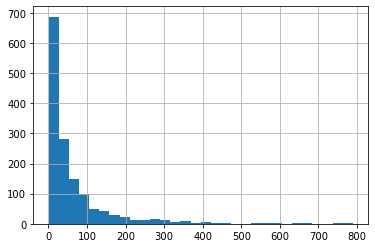

In [33]:
df_final['Previous Close'].hist(bins =30)

In [36]:
df_final.corr().head()

,Previous Close,MARKET_CAP,EPS (TTM),52 Week High 3,52 Week Low 3,50-Day Moving Average 3,200-Day Moving Average 3,"Short Ratio (Sep 15, 2021) 4",Revenue Per Share (ttm),Diluted EPS (ttm),...,Shares Outstanding 5,"Shares Short (Sep 15, 2021) 4","Shares Short (prior month Aug 13, 2021) 4",Revenue (ttm),Gross Profit (ttm),EBITDA,Net Income Avi to Common (ttm),Total Cash (mrq),Total Debt (mrq),Operating Cash Flow (ttm)
Previous Close,1.000000,-0.016724,0.482755,0.982581,0.965419,0.997861,0.991904,-0.030160,0.370056,0.482755,...,0.080368,-0.012031,-0.011068,0.214136,0.256646,0.224608,0.209820,0.206614,0.192433,0.211755
MARKET_CAP,-0.016724,1.000000,-0.011575,-0.016780,-0.027332,-0.015968,-0.016859,-0.018914,0.003385,-0.011575,...,0.019402,0.007912,0.002270,0.025760,-0.000413,0.003515,-0.010234,0.010627,0.054463,0.007467
EPS (TTM),0.482755,-0.011575,1.000000,0.468268,0.496977,0.482552,0.494181,-0.053669,0.394153,1.000000,...,0.031760,-0.038130,-0.036106,0.153174,0.141338,0.130745,0.149969,0.110024,0.105905,0.115338
52 Week High 3,0.982581,-0.016780,0.468268,1.000000,0.958728,0.985652,0.987060,-0.022885,0.358346,0.468268,...,0.067043,-0.008288,-0.008497,0.197804,0.237881,0.206514,0.194785,0.194886,0.172402,0.196698
52 Week Low 3,0.965419,-0.027332,0.496977,0.958728,1.000000,0.966156,0.978427,-0.026871,0.368978,0.496977,...,0.093913,-0.003973,-0.002966,0.242137,0.285936,0.249018,0.228636,0.216188,0.220356,0.228770


In [39]:
df_final.describe()

,Previous Close,MARKET_CAP,EPS (TTM),52 Week High 3,52 Week Low 3,50-Day Moving Average 3,200-Day Moving Average 3,"Short Ratio (Sep 15, 2021) 4",Revenue Per Share (ttm),Diluted EPS (ttm),...,Shares Outstanding 5,"Shares Short (Sep 15, 2021) 4","Shares Short (prior month Aug 13, 2021) 4",Revenue (ttm),Gross Profit (ttm),EBITDA,Net Income Avi to Common (ttm),Total Cash (mrq),Total Debt (mrq),Operating Cash Flow (ttm)
count,1453.000000,1.453000e+03,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,...,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03
mean,61.999680,8.940959e+09,2.082286,77.171032,41.394222,63.386183,61.721521,5.165767,33.732526,2.082286,...,1.663013e+08,4.495546e+06,4.550200e+06,5.200372e+09,1.608332e+09,1.010750e+09,5.170904e+08,1.058260e+09,3.002883e+09,8.318571e+08
std,91.572269,3.430016e+10,8.399380,105.341590,64.016601,95.064175,88.887290,4.580048,68.765256,8.399380,...,5.787338e+08,8.230570e+06,8.339221e+06,1.853658e+10,6.094886e+09,4.549917e+09,3.245128e+09,4.987477e+09,9.937203e+09,4.249137e+09
min,0.353600,1.278000e+07,-86.870000,1.160000,0.066100,0.342900,0.478400,0.010000,-2.000000,-86.870000,...,1.380000e+06,1.690000e+02,2.290000e+02,-3.580000e+06,-5.170000e+09,-6.650000e+09,-6.660000e+09,5.220000e+03,1.500000e+04,-2.119000e+10
25%,9.390000,2.529900e+08,-0.453000,16.040000,5.170000,9.380000,10.230000,2.280000,3.720000,-0.453000,...,2.527000e+07,4.847400e+05,4.927000e+05,1.386300e+08,3.646000e+07,-8.800000e+04,-1.355000e+07,3.417000e+07,2.920000e+07,-4.037900e+05
50%,29.990000,9.705000e+08,0.719000,41.080000,18.000000,30.020000,30.710000,3.930000,13.160000,0.719000,...,5.646000e+07,1.720000e+06,1.750000e+06,6.844000e+08,2.281000e+08,9.429000e+07,2.629000e+07,1.534300e+08,3.543300e+08,7.820000e+07
75%,73.970000,4.720000e+09,3.020000,90.920000,48.000000,75.490000,74.540000,6.670000,34.520000,3.020000,...,1.365400e+08,5.000000e+06,5.140000e+06,3.110000e+09,9.768300e+08,6.091400e+08,2.590500e+08,5.717500e+08,1.900000e+09,4.533100e+08
max,789.320000,6.240800e+11,134.050000,885.260000,586.730000,838.010000,779.580000,32.990000,912.470000,134.050000,...,1.653000e+10,1.009300e+08,9.814000e+07,3.471600e+11,1.158600e+11,1.109300e+11,8.680000e+10,1.302600e+11,1.482300e+11,1.044100e+11


## 3.  Linear regression model

### Baseline linear regression model

In [381]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression,LassoCV,RidgeCV,ElasticNetCV,Lasso,Ridge,ElasticNet
from sklearn.model_selection import (cross_val_score, train_test_split,KFold, GridSearchCV)
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats

In [269]:
df_reg = df_final.copy()
len(df_reg.columns)

35

### a. Drop leverage data points

In [410]:
lev_ls = list(df_reg[df_reg['Previous Close']>1000].index)
df_reg.drop(index = lev_ls,inplace = True)
df_reg.shape

(1453, 35)

### b. Check multicollinearity and drop features with high vif values

In [574]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
y = df_reg['Previous Close']
X = df_reg.drop(labels = ['Previous Close'],axis = 1)
vif = pd.DataFrame()
vif['variables'] = X.columns
vif['vif'] =[variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,variables,vif
0,MARKET_CAP,1.111493e+00
1,EPS (TTM),2.729454e+14
2,52 Week High 3,8.100493e+01
3,52 Week Low 3,4.353032e+01
4,50-Day Moving Average 3,1.507761e+02
5,200-Day Moving Average 3,2.803423e+02
6,"Short Ratio (Sep 15, 2021) 4",3.713118e+00
7,Revenue Per Share (ttm),2.388507e+00
8,Diluted EPS (ttm),4.293231e+12
9,Total Cash Per Share (mrq),2.728272e+00


In [575]:
collinear = ['EPS (TTM)','200-Day Moving Average 3','Shares Short (Sep 15, 2021) 4',
            'EBITDA','52 Week Low 3','Short % of Float (Sep 15, 2021) 4','Net Income Avi to Common (ttm)',
        'Operating Cash Flow (ttm)','Gross Profit (ttm)','Avg Vol (3 month) 3','50-Day Moving Average 3']
X_1 = X.drop(columns = collinear)
X_1.shape

(1453, 23)

In [576]:
vif = pd.DataFrame()
vif['variables'] = X_1.columns
vif['vif'] =[variance_inflation_factor(X_1.values, i) for i in range(X_1.shape[1])]
vif

,variables,vif
0,MARKET_CAP,1.099552
1,52 Week High 3,2.371377
2,"Short Ratio (Sep 15, 2021) 4",3.434277
3,Revenue Per Share (ttm),2.214568
4,Diluted EPS (ttm),2.320948
5,Total Cash Per Share (mrq),2.505984
6,Current Ratio (mrq),1.543698
7,Book Value Per Share (mrq),3.680563
8,52-Week Change 3,1.339279
9,% Held by Insiders 1,1.352254


### c. Split dataset into train/validation and test groups

In [577]:
X_1,X_1_test,y,y_test = train_test_split(X_1,y,test_size= 0.2,random_state=17)
X_1.shape, X_1_test.shape

((1162, 23), (291, 23))

### d. Run baseline linear regression model with historical price info feature

In [578]:
model = sm.OLS(y,sm.add_constant(X_1))
lm_fit = model.fit()
lm_fit.summary()

/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Previous Close   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     1561.
Date:                Tue, 12 Oct 2021   Prob (F-statistic):               0.00
Time:                        10:19:33   Log-Likelihood:                -4847.5
No. Observations:                1162   AIC:                             9743.
Df Residuals:                    1138   BIC:                             9864.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                             -4.2306      2.116     -2.000      0.046      -8.382      -0.079
MARKET_CAP                                      2.721e-12   1.46e-11      0.187      0.852   -2.59e-11    3.13e-11
52 Week High 3                                     0.8172      0.006    145.673      0.000       0.806       0.828
Short Ratio (Sep 15, 2021) 4                       0.4290      0.125      3.422      0.001       0.183       0.675
Revenue Per Share (ttm)                            0.0126      0.009      1.448      0.148      -0.004       0.030
Diluted EPS (ttm)                                  0.2929      0.082      3.554      0.000       0.131       0.455
Total Cash Per Share (mrq)                        -0.1231      0.042     -2.957      0.003      -0.205      -0.041
Current Ratio (mrq)                               -0.3068      0.088     -3.493      0.000      -0.479      -0.134
Book Value Per Share (mrq)                         0.0429      0.022      1.956      0.051      -0.000       0.086
52-Week Change 3                                   0.0234      0.005      4.599      0.000       0.013       0.033
% Held by Insiders 1                              -0.0629      0.037     -1.703      0.089      -0.135       0.010
% Held by Institutions 1                           0.0678      0.025      2.762      0.006       0.020       0.116
Profit Margin                                      0.0134      0.012      1.107      0.269      -0.010       0.037
Operating Margin (ttm)                             0.0026      0.005      0.481      0.631      -0.008       0.013
Short % of Shares Outstanding (Sep 15, 2021) 4    -1.4117      0.156     -9.056      0.000      -1.718      -1.106
Payout Ratio 4                                     0.0177      0.009      2.033      0.042       0.001       0.035
Return on Assets (ttm)                            -0.1159      0.060     -1.942      0.052      -0.233       0.001
Return on Equity (ttm)                             0.0036      0.008      0.473      0.637      -0.011       0.019
Avg Vol (10 day) 3                              3.178e-09   2.45e-08      0.130      0.897   -4.49e-08    5.13e-08
Shares Outstanding 5                            2.549e-10   1.48e-09      0.173      0.863   -2.64e-09    3.15e-09
Shares Short (prior month Aug 13, 2021) 4       1.539e-08   7.68e-08      0.200      0.841   -1.35e-07    1.66e-07
Revenue (ttm)                                  -4.112e-11   4.52e-11     -0.909      0.364    -1.3e-10    4.76e-11
Total Cash (mrq)                                1.498e-10   1.99e-10      0.754      0.451    -2.4e-10    5.39e-10
Total Debt (mrq)                                1.189e-10    7.3e-11      1.629      0.104   

### e. Find out  and drop outliers 

In [579]:
influence = lm_fit.get_influence()
influence_frame = influence.summary_frame().reset_index()

In [580]:
influential_points_count = sum(influence_frame['cooks_d'] >1)
influential_points_count

0

In [581]:
influence_frame[influence_frame['cooks_d'] >1]

,Company,dfb_const,dfb_MARKET_CAP,dfb_52 Week High 3,"dfb_Short Ratio (Sep 15, 2021) 4",dfb_Revenue Per Share (ttm),dfb_Diluted EPS (ttm),dfb_Total Cash Per Share (mrq),dfb_Current Ratio (mrq),dfb_Book Value Per Share (mrq),...,"dfb_Shares Short (prior month Aug 13, 2021) 4",dfb_Revenue (ttm),dfb_Total Cash (mrq),dfb_Total Debt (mrq),cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits


In [582]:
drop_ls = list(influence_frame[influence_frame['cooks_d'] >1]['Company'])

In [583]:
X=X.drop(index = drop_ls )
X_1=X_1.drop(index = drop_ls )
y=y.drop(index = drop_ls )

### Improved linear regression model: use log function to correct non-normality, remove  non-significant feature

In [584]:
non_sig = (['% Held by Insiders 1',
 'Book Value Per Share (mrq)',
 'Current Ratio (mrq)',
 'MARKET_CAP',
 'Operating Margin (ttm)',
 'Revenue (ttm)',
 'Shares Outstanding 5',
 'Short % of Shares Outstanding (Sep 15, 2021) 4',
 'Short Ratio (Sep 15, 2021) 4',
 'Total Cash (mrq)',
 'Total Cash Per Share (mrq)'])


In [585]:
X_1 = X_1.drop(columns = non_sig)
X_1_test = X_1_test.drop(columns = non_sig)

logy = np.log(y)
X_1['log_yearhigh'] = np.log(X['52 Week High 3'])
X_1 = X_1.drop(columns= ['52 Week High 3'])

logy_test = np.log(y_test)
X_1_test['log_yearhigh'] = np.log(X_test['52 Week High 3'])
X_1_test = X_1_test.drop(columns= ['52 Week High 3'])

<AxesSubplot:>

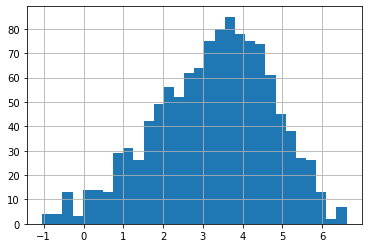

In [586]:
logy.hist(bins =30)

In [587]:
model = sm.OLS(logy,sm.add_constant(X_1))
lm_fit = model.fit()
lm_fit.summary()

/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Previous Close   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     2073.
Date:                Tue, 12 Oct 2021   Prob (F-statistic):               0.00
Time:                        10:19:44   Log-Likelihood:                -287.62
No. Observations:                1162   AIC:                             601.2
Df Residuals:                    1149   BIC:                             667.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                        -0.8530      0.033    -26.042      0.000      -0.917      -0.789
Revenue Per Share (ttm)                       0.0002      0.000      1.452      0.147   -7.47e-05       0.000
Diluted EPS (ttm)                             0.0030      0.001      2.440      0.015       0.001       0.005
52-Week Change 3                              0.0011   9.89e-05     10.967      0.000       0.001       0.001
% Held by Institutions 1                      0.0066      0.000     18.658      0.000       0.006       0.007
Profit Margin                                 0.0007      0.000      3.087      0.002       0.000       0.001
Payout Ratio 4                                0.0010      0.000      6.055      0.000       0.001       0.001
Return on Assets (ttm)                        0.0047      0.001      4.860      0.000       0.003       0.007
Return on Equity (ttm)                        0.0005      0.000      3.277      0.001       0.000       0.001
Avg Vol (10 day) 3                        -2.004e-09   4.71e-10     -4.258      0.000   -2.93e-09   -1.08e-09
Shares Short (prior month Aug 13, 2021) 4 -2.534e-09   1.25e-09     -2.025      0.043   -4.99e-09   -7.83e-11
Total Debt (mrq)                           4.976e-12   1.02e-12      4.858      0.000    2.97e-12    6.99e-12
log_yearhigh                                  0.9760      0.010    100.845      0.000       0.957       0.995
==============================================================================
Omnibus:                      470.545   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3297.909
Skew:                          -1.709   Prob(JB):                         0.00
Kurtosis:                      10.513   Cond. No.                     4.00e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  4e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Drop historical price feature "log_year_high" and do regression only on stock price unrelated features

In [588]:
X_1 = X_1.drop(columns= ['log_yearhigh'])
X_1_test = X_1_test.drop(columns= ['log_yearhigh'])

In [589]:
model = sm.OLS(logy,sm.add_constant(X_1))
lm_fit = model.fit()
lm_fit.summary()

/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Previous Close   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     135.9
Date:                Tue, 12 Oct 2021   Prob (F-statistic):          4.33e-199
Time:                        10:19:48   Log-Likelihood:                -1616.7
No. Observations:                1162   AIC:                             3257.
Df Residuals:                    1150   BIC:                             3318.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                         1.3875      0.076     18.377      0.000       1.239       1.536
Revenue Per Share (ttm)                       0.0026      0.000      5.823      0.000       0.002       0.004
Diluted EPS (ttm)                             0.0274      0.004      7.328      0.000       0.020       0.035
52-Week Change 3                              0.0008      0.000      2.711      0.007       0.000       0.001
% Held by Institutions 1                      0.0240      0.001     24.512      0.000       0.022       0.026
Profit Margin                                 0.0016      0.001      2.201      0.028       0.000       0.003
Payout Ratio 4                                0.0017      0.001      3.228      0.001       0.001       0.003
Return on Assets (ttm)                        0.0146      0.003      4.804      0.000       0.009       0.021
Return on Equity (ttm)                        0.0011      0.000      2.327      0.020       0.000       0.002
Avg Vol (10 day) 3                        -3.909e-09   1.48e-09     -2.649      0.008    -6.8e-09   -1.01e-09
Shares Short (prior month Aug 13, 2021) 4 -7.952e-09   3.92e-09     -2.027      0.043   -1.57e-08   -2.54e-10
Total Debt (mrq)                           1.714e-11   3.19e-12      5.371      0.000    1.09e-11    2.34e-11
==============================================================================
Omnibus:                        4.876   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.087   Jarque-Bera (JB):                4.913
Skew:                           0.158   Prob(JB):                       0.0857
Kurtosis:                       2.964   Cond. No.                     2.88e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.88e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [590]:
model = LinearRegression()
lm=model.fit(X_1,logy)
lm.score(X_1,logy) ,lm.score(X_1_test,logy_test) 

(0.565159656150131, 0.6067569341767368)

### Check regression residual normality 

In [591]:
def diagnostic_plots(y_pred, y_true, resid):
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    g1 = sn.regplot(x=y_pred, y=y_true, ci=False, fit_reg=False, line_kws={'color': 'blue'}, ax=axes[0], scatter_kws={'s': 5})
    g1.set_xlabel('Predicted Target')
    g1.set_ylabel('True Target')
    g1.plot(y_true, y_true, '--', color='gray')

    g2 = sn.regplot(x=y_pred, y=resid, lowess=True, ax=axes[1], line_kws={'color': 'red'}, scatter_kws={'s': 5})
    g2.set_xlabel('Predicted Target')
    g2.set_ylabel('Residual')
    g2.axhline(y=0, color='gray', linestyle='--')

    stats.probplot(resid, dist="norm", plot=axes[2])

    fig.suptitle('Diagnostic Plots');
    fig.tight_layout();

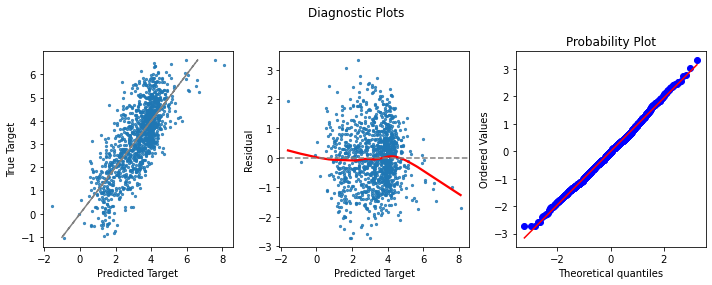

In [592]:
diagnostic_plots(lm_fit.fittedvalues, logy, lm_fit.resid)

In [467]:
#  The Durbin-Watson value is acceptable for residual autocorrelation

## 4. Split Training Data into Multiple Folds

In [468]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

## 5. Cross validation with Linear regression model

In [525]:
lin_reg_cv = LinearRegression()
lm_scores = cross_val_score(lin_reg_cv, X_1, logy, cv=kfold)
print(lm_scores)
# Build the Model
lin_reg_cv.fit(X_1, logy)
print("Linear Reg Mean Score: %3.5f"%(np.mean(lm_scores)), ",train R^2: %3.5f"%(lin_reg_cv.score(X_1, logy)))


[0.55565413 0.5890412  0.53272404 0.48891052 0.46499072]
Linear Reg Mean Score: 0.52626 ,train R^2: 0.56516


In [478]:
y_pred = lin_reg_cv.predict(X_1_test)
print("Linear Regression test R^2:%3.5f"%(r2_score(logy_test, y_pred)))
print("Linear Regression MAE:%3.5f"%(mean_squared_error(logy_test, y_pred)))

Linear Regression test R^2:0.60676
Linear Regression MAE:0.82261


## 6. Add polynomial features

In [485]:
### The resul of R^2 score indicate adding Polynomial feature is not a good model
poly = PolynomialFeatures(degree = 2)
X_1_poly = poly.fit_transform(X_1)
lm_poly_cv = LinearRegression()
scores = cross_val_score(lm_poly,X_1_poly, logy, cv=kfold)
print(scores)
lm_poly_cv.fit(X_1_poly,logy)
print("Polynomial model Mean Score: %3.5f"%(np.mean(scores)))
#lm_poly.score(X_1_poly,logy)


[-1.19175143e+00  1.10432033e-01 -1.27332109e+03 -1.02179202e-01
 -1.74463460e-02]
Polynomial model Mean Score: -254.90441


## 7. Regulation Lasso and CV

In [486]:
from sklearn.pipeline import Pipeline 

In [616]:
steps = [('scaler', StandardScaler()), ('Lasso', Lasso())]
pipeline = Pipeline(steps) # define the pipeline object.
parameteres = {'Lasso__alpha':np.logspace(-4, 0, 50)}
grid_Lasso = GridSearchCV(pipeline, param_grid=parameteres, cv=kfold)

In [617]:
grid_Lasso.fit(X_1,logy)
print( grid_Lasso.best_params_, ", best mean score:",grid_Lasso.best_score_)
print("train score = %3.5f" %(grid_Lasso.score(X_1,logy)),",test score = %3.5f" %(grid_Lasso.score(X_1_test,logy_test)))


{'Lasso__alpha': 0.005179474679231213} , best mean score: 0.5301172637609317
train score = 0.56506 ,test score = 0.60477


In [ ]:
df = pd.DataFrame(grid_Lasso.cv_results_)
df['alpha'] = df.params.apply(lambda val: val['Lasso__alpha'])
plt.semilogx(df.alpha, df.mean_test_score)

In [402]:
y_pred = grid_Lasso.predict(X_1_test)
print("Linear Regression:", r2_score(logy_test,y_pred))

Linear Regression: 0.6047715035973216


## 8. Regulation Ridge and CV

In [614]:
steps = [('scaler', StandardScaler()), ('Ridge', Ridge())]
pipeline = Pipeline(steps) # define the pipeline object.
parameteres = {'Ridge__alpha':np.logspace(0, 3, 300)}
grid_ridge = GridSearchCV(pipeline, param_grid=parameteres, cv=kfold)

{'Ridge__alpha': 94.75205302806543} , best mean score: 0.5308398311258457
train score = 0.56333 ,test score = 0.59820


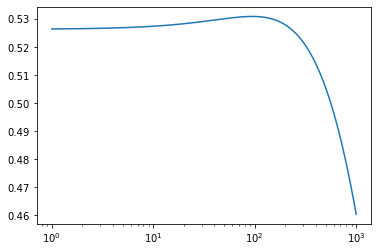

In [615]:
grid_ridge.fit(X_1,logy)
print(grid_ridge.best_params_, ", best mean score:",grid_ridge.best_score_)
print("train score = %3.5f" %(grid_ridge.score(X_1,logy)),",test score = %3.5f" %(grid_ridge.score(X_1_test,logy_test)))
df = pd.DataFrame(grid_ridge.cv_results_)
df['alpha'] = df.params.apply(lambda val: val['Ridge__alpha'])
plt.semilogx(df.alpha, df.mean_test_score)


In [496]:
grid_ridge.best_estimator_.steps[1][1].coef_

array([ 0.19056124,  0.22713699,  0.06621192,  0.70260793,  0.08688298,
        0.09243769,  0.19415436,  0.09665293, -0.07772258, -0.04830542,
        0.1614058 ])

## 9. Regulaiton Elastic Net and CV

In [619]:
steps = [('scaler', StandardScaler()), ('Elastic', ElasticNet())]
pipeline = Pipeline(steps) # define the pipeline object.
parameteres = {'Elastic__alpha':np.logspace(-2, -1, 30),'Elastic__l1_ratio':np.linspace(0, 1, 40)}
grid_elastic = GridSearchCV(pipeline, param_grid=parameteres, cv=kfold)

In [620]:
grid_elastic.fit(X_1,logy)

/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 450.1974675430097, tolerance: 0.20500548780962796
  model = cd_fast.enet_coordinate_descent(
/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 449.91853697234757, tolerance: 0.200571034046003
  model = cd_fast.enet_coordinate_descent(
/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 430.88659649179897, tolerance: 0.1954239517212306
  model = cd_fast.enet_coordinate_descent(
/Users/kristy/opt/anaconda3/envs

/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 452.29565781479397, tolerance: 0.20500548780962796
  model = cd_fast.enet_coordinate_descent(
/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 452.0633884783637, tolerance: 0.200571034046003
  model = cd_fast.enet_coordinate_descent(
/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 433.0199881764458, tolerance: 0.1954239517212306
  model = cd_fast.enet_coordinate_descent(
/Users/kristy/opt/anaconda3/envs/

/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 455.62955882646213, tolerance: 0.20500548780962796
  model = cd_fast.enet_coordinate_descent(
/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 455.469590926854, tolerance: 0.200571034046003
  model = cd_fast.enet_coordinate_descent(
/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 436.4019966800089, tolerance: 0.1954239517212306
  model = cd_fast.enet_coordinate_descent(
/Users/kristy/opt/anaconda3/envs/m

/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 460.8860546555262, tolerance: 0.20500548780962796
  model = cd_fast.enet_coordinate_descent(
/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 460.8355518620394, tolerance: 0.200571034046003
  model = cd_fast.enet_coordinate_descent(
/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 441.7160378269197, tolerance: 0.1954239517212306
  model = cd_fast.enet_coordinate_descent(
/Users/kristy/opt/anaconda3/envs/m

/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 469.07571824172373, tolerance: 0.20500548780962796
  model = cd_fast.enet_coordinate_descent(
/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 469.18488449557066, tolerance: 0.200571034046003
  model = cd_fast.enet_coordinate_descent(
/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 449.9548531411778, tolerance: 0.1954239517212306
  model = cd_fast.enet_coordinate_descent(
/Users/kristy/opt/anaconda3/envs

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('Elastic', ElasticNet())]),
             param_grid={'Elastic__alpha': array([0.01      , 0.01082637, 0.01172102, 0.01268961, 0.01373824,
       0.01487352, 0.01610262, 0.01743329, 0.01887392, 0.0204336 ,
       0.02212216, 0.02395027, 0.02592944, 0.02807216, 0.03039195,
       0.03290345, 0....
       0.12820513, 0.15384615, 0.17948718, 0.20512821, 0.23076923,
       0.25641026, 0.28205128, 0.30769231, 0.33333333, 0.35897436,
       0.38461538, 0.41025641, 0.43589744, 0.46153846, 0.48717949,
       0.51282051, 0.53846154, 0.56410256, 0.58974359, 0.61538462,
       0.64102564, 0.66666667, 0.69230769, 0.71794872, 0.74358974,
       0.76923077, 0.79487179, 0.82051282, 0.84615385, 0.87179487,
       0.8974359 , 0.92307692, 0.94871795, 0.97435897, 1.        ])})

In [621]:
print(grid_elastic.best_params_,", best mean score:",grid_elastic.best_score_)
print("train score = %3.5f" %(grid_elastic.score(X_1,logy)),",test score = %3.5f" %(grid_elastic.score(X_1_test,logy_test)))

df = pd.DataFrame(grid_elastic.cv_results_)


{'Elastic__alpha': 0.06723357536499334, 'Elastic__l1_ratio': 0.02564102564102564} , best mean score: 0.5312097859513275
train score = 0.56379 ,test score = 0.59929


In [622]:
intercept = grid_elastic.best_estimator_.steps[1][1].intercept_
coef = grid_elastic.best_estimator_.steps[1][1].coef_

In [623]:
coef_df = pd.DataFrame([list(X_1.columns),coef]).transpose()
coef_df.columns = ['Feature','coefficent']

In [624]:
intercept,coef_df

(3.2421367076548813,
                                       Feature coefficent
 0                     Revenue Per Share (ttm)   0.189678
 1                           Diluted EPS (ttm)   0.228899
 2                            52-Week Change 3   0.066463
 3                    % Held by Institutions 1    0.71223
 4                               Profit Margin   0.085392
 5                              Payout Ratio 4   0.091668
 6                      Return on Assets (ttm)   0.194229
 7                      Return on Equity (ttm)   0.094993
 8                          Avg Vol (10 day) 3  -0.076562
 9   Shares Short (prior month Aug 13, 2021) 4  -0.049132
 10                           Total Debt (mrq)   0.162104)

Compare all regulation regression results

In [625]:
print("Linear Reg Mean Score: %3.5f"%(np.mean(lm_scores)))
print( "Lasso CV best mean score:%3.5f"%(grid_Lasso.best_score_), ", param is",grid_Lasso.best_params_)
print( "Ridge CV best mean score:%3.5f"%(grid_ridge.best_score_), ", param is",grid_ridge.best_params_)
print( "Elastic CV best mean score:%3.5f"%(grid_elastic.best_score_), ", param is",grid_elastic.best_params_)

Linear Reg Mean Score: 0.52626
Lasso CV best mean score:0.53012 , param is {'Lasso__alpha': 0.005179474679231213}
Ridge CV best mean score:0.53084 , param is {'Ridge__alpha': 94.75205302806543}
Elastic CV best mean score:0.53121 , param is {'Elastic__alpha': 0.06723357536499334, 'Elastic__l1_ratio': 0.02564102564102564}


count    1.162000e+03
mean     2.356612e+06
std      2.000629e+07
min      1.200000e+02
25%      1.334200e+05
50%      4.216650e+05
75%      1.255000e+06
max      6.293300e+08
Name: Avg Vol (10 day) 3, dtype: float64

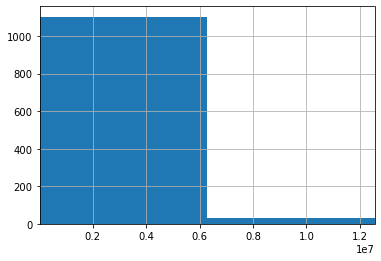

In [653]:
X_1['Avg Vol (10 day) 3'].hist(bins =100)
plt.xlim(1.334200e+04,1.255000e+07)
X_1['Avg Vol (10 day) 3'].describe()

In [655]:
1-np.e**-0.049132

0.04794454991557828

## 10. What if feed all non-price-related features to ElasticNet model

In [626]:
y = df_reg['Previous Close']
X = df_reg.drop(labels = ['Previous Close'],axis = 1)

In [627]:
X_2,X_2_test,y,y_test = train_test_split(X,y,test_size= 0.2,random_state=17)
X_2.shape, X_2_test.shape

((1162, 34), (291, 34))

In [628]:
X_2.drop(columns =['52 Week High 3','52 Week Low 3','50-Day Moving Average 3','200-Day Moving Average 3'],inplace = True)
X_2_test.drop(columns =['52 Week High 3','52 Week Low 3','50-Day Moving Average 3','200-Day Moving Average 3'],inplace = True)

/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [629]:
logy = np.log(y)
logy_test = np.log(y_test)

In [630]:
grid_elastic_check = grid_elastic.fit(X_2,logy)

/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 405.08377939421894, tolerance: 0.20500548780962796
  model = cd_fast.enet_coordinate_descent(
/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 408.0700324210067, tolerance: 0.200571034046003
  model = cd_fast.enet_coordinate_descent(
/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 393.2790257477996, tolerance: 0.1954239517212306
  model = cd_fast.enet_coordinate_descent(
/Users/kristy/opt/anaconda3/envs/

/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 408.41692589390976, tolerance: 0.20500548780962796
  model = cd_fast.enet_coordinate_descent(
/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 411.53931681574306, tolerance: 0.200571034046003
  model = cd_fast.enet_coordinate_descent(
/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 396.60671799498084, tolerance: 0.1954239517212306
  model = cd_fast.enet_coordinate_descent(
/Users/kristy/opt/anaconda3/env

/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 413.3489236802482, tolerance: 0.20500548780962796
  model = cd_fast.enet_coordinate_descent(
/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 416.683725675846, tolerance: 0.200571034046003
  model = cd_fast.enet_coordinate_descent(
/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 401.53302065338613, tolerance: 0.1954239517212306
  model = cd_fast.enet_coordinate_descent(
/Users/kristy/opt/anaconda3/envs/m

/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 420.50447794170884, tolerance: 0.20500548780962796
  model = cd_fast.enet_coordinate_descent(
/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 424.10367123413585, tolerance: 0.200571034046003
  model = cd_fast.enet_coordinate_descent(
/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 408.6552197862522, tolerance: 0.1954239517212306
  model = cd_fast.enet_coordinate_descent(
/Users/kristy/opt/anaconda3/envs

/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 430.63526625507683, tolerance: 0.20500548780962796
  model = cd_fast.enet_coordinate_descent(
/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 434.4767565805024, tolerance: 0.200571034046003
  model = cd_fast.enet_coordinate_descent(
/Users/kristy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 418.66398771876703, tolerance: 0.1954239517212306
  model = cd_fast.enet_coordinate_descent(
/Users/kristy/opt/anaconda3/envs

In [631]:
print(grid_elastic_check.best_params_,", best mean score:",grid_elastic_check.best_score_)
print("train score = %3.5f" %(grid_elastic_check.score(X_2,logy)),",test score = %3.5f" %(grid_elastic_check.score(X_2_test,logy_test)))

{'Elastic__alpha': 0.03290344562312668, 'Elastic__l1_ratio': 0.05128205128205128} , best mean score: 0.535064977234583
train score = 0.60647 ,test score = 0.57519


In [632]:
intercept_check = grid_elastic.best_estimator_.steps[1][1].intercept_
coef_check = grid_elastic.best_estimator_.steps[1][1].coef_

In [633]:
coef_df_check = pd.DataFrame([list(X_2.columns),coef_check]).transpose()
coef_df_check.columns = ['Feature','coefficent']

In [634]:
coef_df_check

,Feature,coefficent
0,MARKET_CAP,-0.000644
1,EPS (TTM),0.025295
2,"Short Ratio (Sep 15, 2021) 4",-0.0
3,Revenue Per Share (ttm),0.147927
4,Diluted EPS (ttm),0.02288
5,Total Cash Per Share (mrq),0.12549
6,Current Ratio (mrq),0.017106
7,Book Value Per Share (mrq),0.1757
8,52-Week Change 3,0.070312
9,% Held by Insiders 1,0.158532


## 11.  linear regression with dummy variables "Industry"

In [434]:
X_1 = (X.drop(columns =
              ['EPS (TTM)','200-Day Moving Average 3','Shares Short (Sep 15, 2021) 4',
            'EBITDA','52 Week Low 3','Short % of Float (Sep 15, 2021) 4','Net Income Avi to Common (ttm)',
        'Operating Cash Flow (ttm)','Gross Profit (ttm)','Avg Vol (3 month) 3','50-Day Moving Average 3',
               'MARKET_CAP','Total Cash Per Share (mrq)','% Held by Insiders 1','Book Value Per Share (mrq)',
               'Total Cash (mrq)','Shares Short (prior month Aug 13, 2021) 4','Current Ratio (mrq)','Revenue (ttm)',
               'Operating Margin (ttm)','Short Ratio (Sep 15, 2021) 4','Short % of Shares Outstanding (Sep 15, 2021) 4','Shares Outstanding 5'])
      )
X_1_test = (X_test.drop(columns =
              ['EPS (TTM)','200-Day Moving Average 3','Shares Short (Sep 15, 2021) 4',
            'EBITDA','52 Week Low 3','Short % of Float (Sep 15, 2021) 4','Net Income Avi to Common (ttm)',
        'Operating Cash Flow (ttm)','Gross Profit (ttm)','Avg Vol (3 month) 3','50-Day Moving Average 3',
               'MARKET_CAP','Total Cash Per Share (mrq)','% Held by Insiders 1','Book Value Per Share (mrq)',
              'Total Cash (mrq)','Shares Short (prior month Aug 13, 2021) 4','Current Ratio (mrq)','Revenue (ttm)',
              'Operating Margin (ttm)','Short Ratio (Sep 15, 2021) 4','Short % of Shares Outstanding (Sep 15, 2021) 4','Shares Outstanding 5'])
      )
logy = np.log(y)
#X_1['log_yearhigh'] = np.log(X_1['52 Week High 3'])
X_1.drop(columns= ['52 Week High 3'],inplace  = True)

logy_test = np.log(y_test)
#X_1_test['log_yearhigh'] = np.log(X_1_test['52 Week High 3'])
X_1_test.drop(columns= ['52 Week High 3'],inplace  = True)

In [435]:
X_dummy = pd.merge(df_ticker[['Ticker','Industry']],X_1,left_on='Ticker',right_index=True)
X_dummy.set_index('Ticker',inplace= True)
X_dummy_test =pd.merge(df_ticker[['Ticker','Industry']],X_1_test,left_on='Ticker',right_index=True)
X_dummy_test.set_index('Ticker',inplace= True)

In [436]:
logy = logy.to_frame()
df_dummy = pd.merge(logy,X_dummy,left_index=True,right_index=True)
df_dummy

,Previous Close,Industry,Revenue Per Share (ttm),Diluted EPS (ttm),52-Week Change 3,% Held by Institutions 1,Profit Margin,Payout Ratio 4,Return on Assets (ttm),Return on Equity (ttm),Avg Vol (10 day) 3,Total Debt (mrq)
PG,4.932962,Household Products,30.87,5.50,-0.59,65.43,18.79,58.94,9.79,30.69,6090000.0,3.284000e+10
MCF,1.534714,"Oil, Gas & Consumable Fuels",1.20,-0.41,254.20,25.97,-33.80,0.00,-12.29,-287.49,1490000.0,7.979000e+07
SRE,4.840400,Multi-Utilities,39.81,6.78,3.51,87.65,18.61,62.08,2.29,8.78,1580000.0,2.531000e+10
AEL,3.404525,Insurance,41.21,9.13,-3.25,98.29,23.38,3.46,1.04,15.92,279360.0,5.742200e+08
NWPX,3.186766,Construction & Engineering,29.85,1.69,-10.13,85.90,5.73,0.00,3.43,6.33,30970.0,3.494000e+07
...,...,...,...,...,...,...,...,...,...,...,...,...
CNTY,2.651833,"Hotels, Restaurants & Leisure",11.67,0.54,174.27,73.83,4.61,0.00,4.94,12.56,113340.0,4.990200e+08
SMG,4.985317,Chemicals,91.16,9.87,-3.66,63.77,11.11,24.95,11.87,53.62,428520.0,2.420000e+09
APPS,4.263243,Software,5.22,0.60,99.72,65.30,12.68,0.00,5.74,19.22,2940000.0,2.738000e+08
PTON,4.410978,Leisure Products,13.69,-0.64,-26.02,84.29,-4.70,0.00,-2.43,-11.01,8120000.0,1.510000e+09


In [437]:
Industry_count = X_dummy.Industry.value_counts()
other_industry = list(Industry_count[Industry_count<30].index)
Industry_count[:15]

Biotechnology                               85
Software                                    80
Health Care Equipment & Supplies            65
Equity Real Estate Investment Trusts...     64
Oil, Gas & Consumable Fuels                 55
Insurance                                   46
IT Services                                 46
Machinery                                   45
Electronic Equipment, Instruments & C...    44
Specialty Retail                            44
Semiconductors & Semiconductor Equipment    44
Health Care Providers & Services            41
Pharmaceuticals                             38
Chemicals                                   34
Hotels, Restaurants & Leisure               34
Name: Industry, dtype: int64

In [438]:
df_dummy['Industry'] = df_dummy['Industry'] .replace(other_industry, 'other')

In [439]:
df_dummy = pd.get_dummies(df_dummy, drop_first=True)

In [440]:
y = df_dummy['Previous Close']
x = df_dummy.drop(columns = ['Previous Close'])
x['intercept'] = 1

model = sm.OLS(y, x)
fit = model.fit()

r_squared = round(fit.rsquared, 3)

In [441]:
#df_dummy.groupby('Industry')['Previous Close'].mean().to_frame().sort_values('Previous Close',ascending= False)

In [442]:
r_squared

0.601

In [443]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Previous Close   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     63.30
Date:                Mon, 11 Oct 2021   Prob (F-statistic):          1.43e-204
Time:                        18:27:32   Log-Likelihood:                -1566.5
No. Observations:                1162   AIC:                             3189.
Df Residuals:                    1134   BIC:                             3331.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Revenue Per Share (ttm)                               0.0034      0.000      7.538      0.000       0.003       0.004
Diluted EPS (ttm)                                     0.0258      0.004      7.014      0.000       0.019       0.033
52-Week Change 3                                      0.0011      0.000      3.590      0.000       0.001       0.002
% Held by Institutions 1                              0.0227      0.001     23.652      0.000       0.021       0.025
Profit Margin                                         0.0016      0.001      2.178      0.030       0.000       0.003
Payout Ratio 4                                        0.0023      0.001      3.975      0.000       0.001       0.003
Return on Assets (ttm)                                0.0159      0.003      5.313      0.000       0.010       0.022
Return on Equity (ttm)                                0.0010      0.000      2.209      0.027       0.000       0.002
Avg Vol (10 day) 3                                -4.653e-09   1.42e-09     -3.267      0.001   -7.45e-09   -1.86e-09
Total Debt (mrq)                                   1.465e-11   2.76e-12      5.314      0.000    9.24e-12    2.01e-11
Industry_Chemicals                                   -0.0130      0.221     -0.059      0.953      -0.446       0.420
Industry_Electronic Equipment, Instruments & C...     0.0238      0.197      0.121      0.904      -0.363       0.411
Industry_Energy Equipment & Services                 -0.7968      0.226     -3.532      0.000      -1.239      -0.354
Industry_Equity Real Estate Investment Trusts...     -0.0743      0.194     -0.383      0.702      -0.455       0.306
Industry_Food Products                                0.0814      0.227      0.359      0.720      -0.363       0.526
Industry_Health Care Equipment & Supplies             0.3378      0.179      1.892      0.059      -0.013       0.688
Industry_Health Care Providers & Services            -0.1748      0.209     -0.835      0.404      -0.586       0.236
Industry_Hotels, Restaurants & Leisure               -0.0616      0.214     -0.287      0.774      -0.482       0.359
Industry_IT Services                                  0.4952      0.194      2.549      0.011       0.114       0.876
Industry_Insurance                                    0.1214      0.213      0.569      0.570      -0.297       0.540
Industry_Machinery                                    0.1427      0.208      0.684      0.494      -0.266       0.552
Industry_Oil, Gas & Consumable Fuels                 -0.2092      0.201     -1.041      0.298      -0.603       0.185
Industry_Pharmaceuticals                             -0.2141      0.201     -1.066      0.286      -0.608       0.180
Industry_Semico